# MiDaS Monocular Depth Estimation

### Installation
This cell installs the necessary Python libraries: `opencv-python` for image and video processing, and `torch`, `torchvision`, `torchaudio` for the PyTorch deep learning framework, which is used by the MiDaS model.

In [1]:
!pip install opencv-python
!pip install torch torchvision torchaudio

### Imports
This cell imports the required modules: `cv2` for OpenCV operations, `torch` for PyTorch, `numpy` for numerical operations, and `time` for measuring execution time and delays.

In [2]:
import cv2
import torch
import numpy as np
import time

### MiDaSDepthEstimator Class
This class encapsulates the functionality for real-time depth estimation using the MiDaS model. It handles model loading, device selection (CPU/GPU), image transformation, depth prediction, and colormap application for visualization.

-   `__init__`: Initializes the depth estimator, loading the specified MiDaS model variant (e.g., 'DPT_Hybrid') and its associated transformations.
-   `estimate_depth`: Takes an OpenCV BGR image frame as input, converts it to RGB, applies the necessary transformations, and uses the MiDaS model to predict and normalize a grayscale depth map.
-   `apply_colormap`: Applies an OpenCV colormap to the grayscale depth map for better visual interpretation.

In [3]:
class MiDaSDepthEstimator:
    """Real-time depth estimation using MiDaS model"""

    def __init__(self, model_type="DPT_Large"):
        """
        Initialize MiDaS depth estimator

        Args:
            model_type: Model variant to use
                - "DPT_Large" (highest accuracy, slower)
                - "DPT_Hybrid" (good balance)
                - "MiDaS_small" (fastest, lower accuracy)
        """
        print(f"Loading MiDaS model: {model_type}...")

        # Load MiDaS model from torch hub
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # Load model
        self.model = torch.hub.load("intel-isl/MiDaS", model_type)
        self.model.to(self.device)
        self.model.eval()

        # Load transforms
        midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

        if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
            self.transform = midas_transforms.dpt_transform
        else:
            self.transform = midas_transforms.small_transform

        print("Model loaded successfully!")

    def estimate_depth(self, frame):
        """
        Estimate depth from a single frame

        Args:
            frame: Input BGR image from OpenCV

        Returns:
            depth_map: Normalized depth map (0-255)
        """
        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Apply transforms
        input_batch = self.transform(img_rgb).to(self.device)

        # Predict depth
        with torch.no_grad():
            prediction = self.model(input_batch)

            # Resize to original resolution
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=img_rgb.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze()

        # Convert to numpy
        depth_map = prediction.cpu().numpy()

        # Normalize to 0-255 for visualization
        depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        return depth_map

    def apply_colormap(self, depth_map, colormap=cv2.COLORMAP_MAGMA):
        """
        Apply colormap to depth map for better visualization

        Args:
            depth_map: Grayscale depth map
            colormap: OpenCV colormap to apply

        Returns:
            colored_depth: Colored depth map
        """
        return cv2.applyColorMap(depth_map, colormap)


### Main Function
This `main` function orchestrates the depth estimation process. It initializes the `MiDaSDepthEstimator`, opens a video file (or attempts webcam access if not in Colab), processes each frame to estimate depth, applies a colormap, and displays the original and depth frames side-by-side. It also includes controls for quitting, changing colormaps, and saving frames.

In [32]:
def main(video_path="video.mp4"): # Modified to accept a video_path
    """Main function for live depth estimation"""

    # Initialize depth estimator
    # Options: "DPT_Large", "DPT_Hybrid", "MiDaS_small"
    estimator = MiDaSDepthEstimator(model_type="DPT_Hybrid")

    # Open webcam or video file
    if video_path:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video file at {video_path}")
            return
        print(f"Processing video file: {video_path}")
    else:
        # For Colab, direct webcam access is not possible.
        # If running locally, you can use cv2.VideoCapture(0)
        print("Error: Direct webcam access is not supported in Colab.")
        print("Please provide a video_path to the main() function or run this code locally.")
        return

    # Set camera resolution (optional, may not apply to all videos)
    if not video_path: # Only set for live camera, not fixed resolution video
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

    print("\nStarting depth estimation...")
    print("Press 'q' to quit")
    print("Press 'c' to change colormap")
    print("Press 's' to save current frame and depth map")

    # Available colormaps
    colormaps = [
        cv2.COLORMAP_MAGMA,
        cv2.COLORMAP_INFERNO,
        cv2.COLORMAP_PLASMA,
        cv2.COLORMAP_VIRIDIS,
        cv2.COLORMAP_JET,
        cv2.COLORMAP_TURBO,
    ]
    colormap_names = ["MAGMA", "INFERNO", "PLASMA", "VIRIDIS", "JET", "TURBO"]
    current_colormap_idx = 0

    frame_count = 0
    fps_start_time = time.time()
    fps = 0

    while True:
        ret, frame = cap.read()

        if not ret:
            print("End of video or Error: Could not read frame")
            break

        # Estimate depth
        depth_map = estimator.estimate_depth(frame)

        # Apply colormap
        colored_depth = estimator.apply_colormap(depth_map, colormaps[current_colormap_idx])

        # Calculate FPS
        frame_count += 1
        if frame_count >= 10:
            fps_end_time = time.time()
            fps = frame_count / (fps_end_time - fps_start_time)
            fps_start_time = fps_end_time
            frame_count = 0

        # Add text overlays
        cv2.putText(frame, f"FPS: {fps:.1f}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(colored_depth, f"Colormap: {colormap_names[current_colormap_idx]}",
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(colored_depth, f"FPS: {fps:.1f}", (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        # Create side-by-side display
        combined = np.hstack((frame, colored_depth))

        # Display
        cv2.imshow('MiDaS Depth Estimation - Original | Depth', combined)

        # Handle key presses
        key = cv2.waitKey(1) & 0xFF

        if key == ord('q'):
            break
        elif key == ord('c'):
            # Cycle through colormaps
            current_colormap_idx = (current_colormap_idx + 1) % len(colormaps)
            print(f"Colormap changed to: {colormap_names[current_colormap_idx]}")
        elif key == ord('s'):
            # Save current frame and depth map
            timestamp = time.strftime("%Y%m%d_%H%M%S")
            cv2.imwrite(f"frame_{timestamp}.jpg", frame)
            cv2.imwrite(f"depth_{timestamp}.jpg", colored_depth)
            print(f"Saved frame_{timestamp}.jpg and depth_{timestamp}.jpg")

    # Cleanup
    cap.release()
    cv2.destroyAllWindows()
    print("\nDepth estimation stopped.")

## Download Video

### Subtask:
Download the video from the provided YouTube Shorts URL using `yt-dlp`.


In [11]:
import sys
!pip install yt-dlp

In [21]:
import os

video_url = "https://youtube.com/shorts/9qOfxnRKtk4?si=na4MRrIu1KEku_W6"
output_filename = "video.mp4"

# Check if the video already exists to avoid re-downloading
if not os.path.exists(output_filename):
    print(f"Downloading video from {video_url}...")
    !yt-dlp -o {output_filename} {video_url}
    print(f"Video downloaded and saved as {output_filename}")
else:
    print(f"Video file '{output_filename}' already exists. Skipping download.")


[youtube] Extracting URL: https://youtube.com/shorts/9qOfxnRKtk4?si=na4MRrIu1KEku_W6
[youtube] 9qOfxnRKtk4: Downloading webpage
[youtube] 9qOfxnRKtk4: Downloading android sdkless player API JSON
[youtube] 9qOfxnRKtk4: Downloading web safari player API JSON
[youtube] 9qOfxnRKtk4: Downloading m3u8 information
[info] 9qOfxnRKtk4: Downloading 1 format(s): 335+251
[download] Destination: video.mp4.f335.webm
[download] 100% of    4.31MiB in 00:00:00 at 34.44MiB/s
[download] Destination: video.mp4.f251.webm
[download] 100% of  144.06KiB in 00:00:00 at 2.71MiB/s
[Merger] Merging formats into "video.mp4.webm"
Deleting original file video.mp4.f335.webm (pass -k to keep)
Deleting original file video.mp4.f251.webm (pass -k to keep)
Video downloaded and saved as video.mp4


## Depth Estimation full video

### Subtask:
Modify the `main` function call in the last code cell to use the local path of the downloaded video file.


In [37]:
# if __name__ == "__main__":
    # To run this code in Colab, you need to upload a video file.
    # Replace 'your_video.mp4' with the path to your uploaded video.
    # For example, after uploading 'my_video.mp4' to your Colab files,
    # you would use video_path = 'my_video.mp4'

    # For demonstration, I will keep it without a video path, which will show the error
    # indicating that webcam access is not possible.
    # If you have a video, uncomment the line below and provide the path.
    # main(video_path='video.mp4')
    # main() # Commented out this line

# First frame depth estimation

Extracted first_frame.jpg from video.mp4
Processing image: first_frame.jpg
Loading MiDaS model: DPT_Hybrid...
Using device: cpu


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Model loaded successfully!
Displaying original and depth images (Original | Depth):


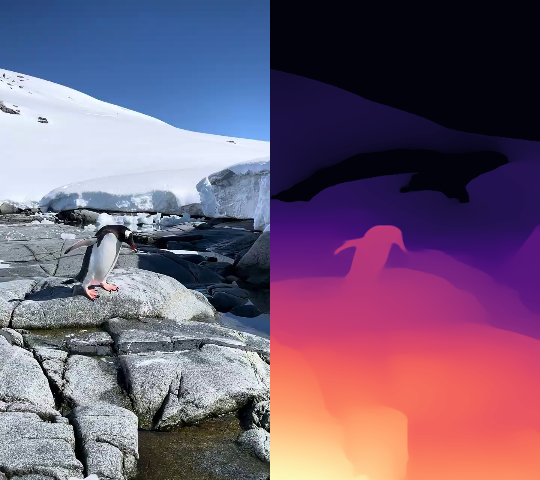

Depth estimation for image complete.


In [35]:
from google.colab.patches import cv2_imshow # For displaying images in Colab

def estimate_depth_for_image(image_path):
    """Estimates and displays depth for a single image."""
    print(f"Processing image: {image_path}")

    # Initialize depth estimator
    # Options: "DPT_Large", "DPT_Hybrid", "MiDaS_small"
    estimator = MiDaSDepthEstimator(model_type="DPT_Hybrid")

    # Load the image
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return

    # Estimate depth
    depth_map = estimator.estimate_depth(img)

    # Apply colormap (using MAGMA by default)
    colored_depth = estimator.apply_colormap(depth_map, colormap=cv2.COLORMAP_MAGMA)

    # Resize for display if images are too large
    display_height = 480
    scale_factor = display_height / img.shape[0]
    display_width_orig = int(img.shape[1] * scale_factor)
    display_width_depth = int(colored_depth.shape[1] * scale_factor)

    resized_img = cv2.resize(img, (display_width_orig, display_height))
    resized_colored_depth = cv2.resize(colored_depth, (display_width_depth, display_height))

    # Create side-by-side display
    combined_display = np.hstack((resized_img, resized_colored_depth))

    # Display using cv2_imshow for Colab
    print("Displaying original and depth images (Original | Depth):")
    cv2_imshow(combined_display)

    print("Depth estimation for image complete.")

# Example usage with the downloaded video's first frame
# To get a single frame from the video, you would typically read it once
# For simplicity, let's assume we want to process a pre-saved image or a frame extracted from the video.
# Since we downloaded 'video.mp4', let's use that to extract a frame.

cap_for_frame = cv2.VideoCapture('video.mp4')
if cap_for_frame.isOpened():
    ret, frame = cap_for_frame.read()
    if ret:
        cv2.imwrite('first_frame.jpg', frame)
        print("Extracted first_frame.jpg from video.mp4")
        estimate_depth_for_image('first_frame.jpg')
    else:
        print("Could not read first frame from video.mp4")
    cap_for_frame.release()
else:
    print("Could not open video.mp4 to extract a frame for image depth estimation example.")
